# PHYSICS 3G03 HW 2: Momentum accelerated and normalized gradient descent, Hessians and linear regression {-}
## Matthew Bain (001406931) {-}

We start by importing all the Python libraries we will need for this project. We also define some global parameters.

In [3]:
# fundamentals
import numpy.linalg as LA           # linalg module of numpy for efficient vector/matrix computations
import pandas as pd                 # pandas for data manipulation

# libraries for computing gradient descent
import autograd.numpy as np         # autograd-wrapped numpy for vectorization functionality etc.
from autograd import grad           # module for computing gradients
from autograd import value_and_grad # autograd function that returns gradient and value of input function

## plotting libraries
import matplotlib.pyplot as plt     # pyplot module of matplotlib for plotting

# from mlrefined_libraries >  math_optimization_library import 'static_plotter' function
from imports import static_plotter
static_plotter = static_plotter.Visualizer()

# global plotting parameters
plt_clrs = (np.array([94,255,231])/360, np.array([133,94,214])/360, np.array([110,250,152])/360)

*note*: the function `static_plotter` imported above produces contour plots and comes from the *Machine Learning Refined* repository [(Watt, 2020)](https://github.com/jermwatt/machine_learning_refined).

## **Exercise 1** *Momentum accelerated gradient descent* {-}

**1.1** In this exercise we implement momentum accelerated gradient descent.

In [4]:
### GD function - inputs: g (cost function), alpha (steplength), max_its (max iterations), w (initial point)
def momentum_GD(w, g, alpha, beta, max_its):

    # compute gradient module
    gradient = value_and_grad(g)

    # containers to track GD values; store initial position & cost
    weight_history = [w]    # weight
    cost_history = [g(w)]   # corresponding cost
    dir_history = []        # descent direction

    ## run gradient descent optimization
    for it in range(max_its):
        # evaluate cost and gradient for current step
        cost_eval, grad_eval = gradient(weight_history[-1])

        # compute descent direction
        if it == 0:
            # for initial step
            dir_eval = (-1)*(grad_eval)
        else:
            # for all other steps
            dir_eval = (beta)*dir_history[-1] + (1-beta)*(-1)*(grad_eval)

        # take momentum-accelerated GD step
        w = weight_history[-1] + alpha*dir_eval

        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
        dir_history.append(dir_eval)

    return weight_history, cost_history, dir_history

**1.2** In this exercise we test our implementation of momentum accelerated gradient descent.

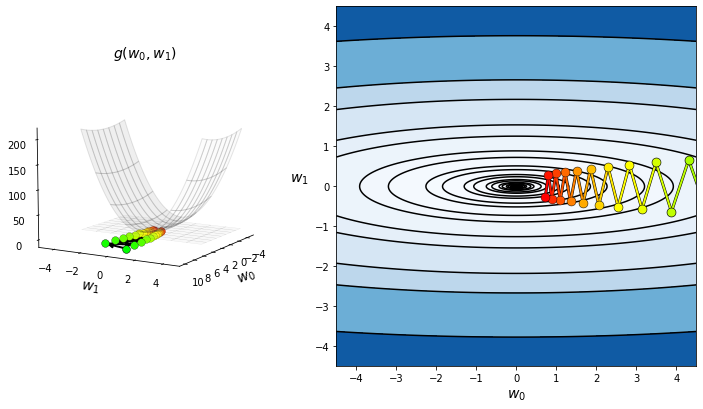

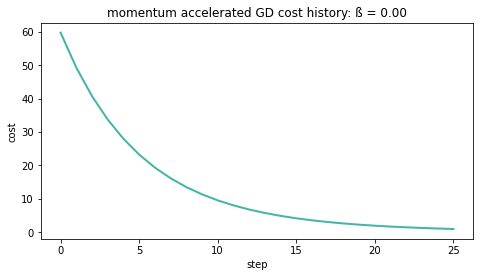

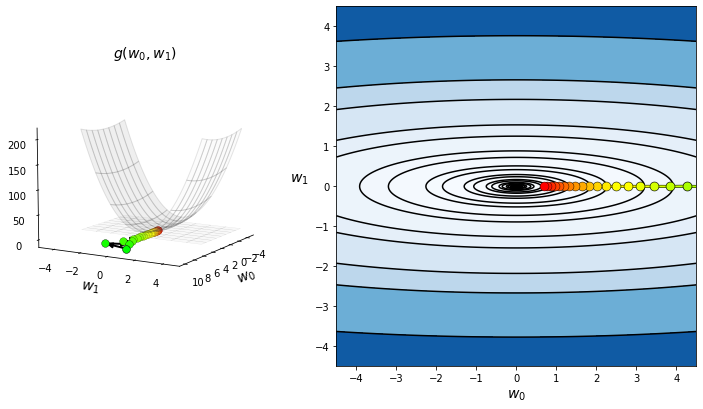

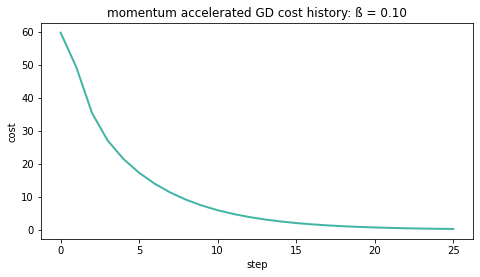

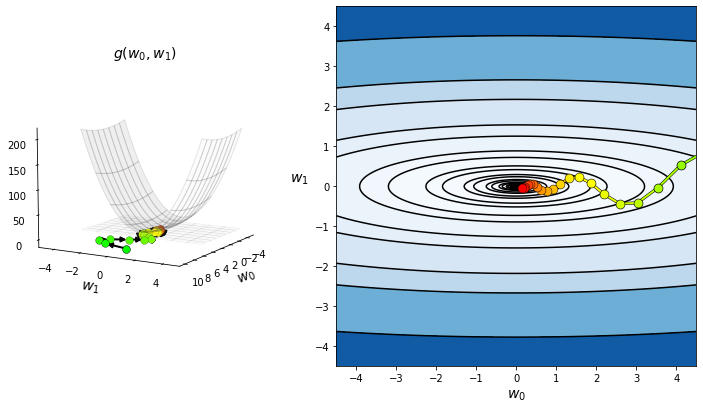

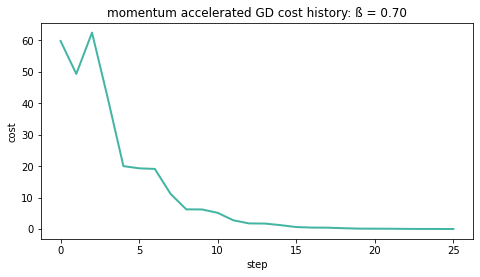

In [5]:
# define cost function (paraboloid, squished in the x-dimension by a factor of 2)
C = np.array([[0.5,0], [0,9.75]])   # matrix that compresses/stretches g along its axes
g = lambda w: (np.dot(np.dot(w.T, C), w))

# define parameters for momentum accelerated GD
w = np.array([10.0,1.0])
alpha = .1
beta = [0, .1, .7]
max_its = 25

# to prevent warning messages from appearing in the report
import warnings;
warnings.filterwarnings('ignore')

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## run GD and plot for each beta value
for b in beta:
    # run GD
    weight_history, cost_history, dir_history = momentum_GD(w, g, alpha, b, max_its)

    # contour plot of g(w) with weight_history overlaid
    w_history = np.array(weight_history)
    static_plotter.two_input_surface_contour_plot(
        g, w_history, view = [10, 30], xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5, num_contours = 50)

    # plot cost_history
    x = range(0, len(weight_history), 1)
    y = cost_history

    fig = plt.figure(figsize = (6, 3), frameon = 0)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(x, y, color = plt_clrs[0], linewidth = 2)

    ax.set_xlabel('step')
    ax.set_ylabel('cost')
    plt.title("momentum accelerated GD cost history: ß = %.2f" % b)

From the plots above, we observe that for each value of $\beta$, momentum accelerated gradient descent appears to converge on the same minimum value, $\omega = (0,0)$, which occurs at $g(0) = 0$. The pattern of approaching $\omega$ values through which this occurs appears to depend on the value of $\beta$. Beta determines the relative importance given by the momentum accelerated gradient descent algorithm to the current direction (i.e., the gradient at the current $\omega$ value) and the exponential average of all previous directions. The most direct approach is achieved at $\beta = .1$. At $\beta = 0$, the algorithm only considers current directions, as in gradient descent (without momentum). As a result we can see the 'zig-zagging' behaviour of gradient descent on full display. For narrow functions like $g$, gradient descent's lack of 'memory' for earlier descent directions prevents it from developing 'momentum' in the direction of the global minimum. Instead it jumps back-and-forth between steep edges of the function.

## **Exercise 2** *Slow-crawling behavior of gradient descent* {-}

In this exercise we compare standard and normalized gradient descent.

We start by defining the standard gradient descent algorithm and add an option to normalize descent directions, as in fully normalized gradient descent. The parameter `fnorm` takes a value 0 for standard gradient descent and 1 for normalized gradient descent.

In [6]:
### define standard/fully normalized gradient descent algorithm
def gradient_descent(g, alpha, max_its, w, **kwargs):
    # value added to 'step' of normed GD to prevent division by 0 where norm vanishes
    eps = 10e-7

    # store value of optional (keyword) argument
    fnorm = kwargs.get('fnorm', 0)

    # compute gradient module using autograd
    gradient = grad(g)

    ## run gradient descent loop
    weight_history = [w] # weight history container
    cost_history = [g(w)] # cost function history container
    for k in range(max_its):
        # evaluate the gradient
        grad_eval = gradient(w)

        ## take gradient descent step
        # fully normalized step
        if fnorm == 1:
            # compute norm of current gradient vector
            grad_norm = LA.norm(grad_eval)

            # take a step
            w = weight_history[-1] - (alpha / (grad_norm + eps))*grad_eval
        # standard step
        elif fnorm == 0:
            w = weight_history[-1] - alpha*grad_eval

        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history, cost_history

We now definine our cost function and parameters.

In [7]:
# define cost function
g = lambda w: np.tanh(4*w[0] + 4*w[1]) + max(1, .4*(w[0]**2)) + 1

# define parameters
w = np.array([2.,2.])
alpha = .1
max_its = 1000

Below we run the standard and fully normalized gradient descent functions for the above parameters. We compare the results of the two algorithms by plotting the corresponding cost histories.

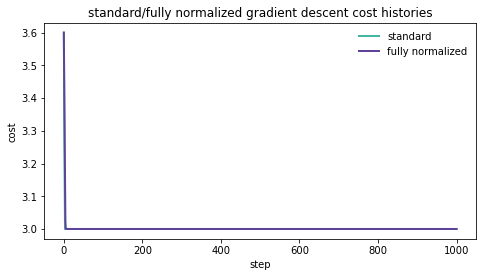

In [8]:
## run gradient descent
weight_history_std, cost_history_std = gradient_descent(g, alpha, max_its, w, fnorm = 0)
weight_history_fnorm, cost_history_fnorm = gradient_descent(g, alpha, max_its, w, fnorm = 1)

## plot and overlay cost histories for comparison
# store data
x = list(range(0, max_its+1, 1))
y_std = cost_history_std
y_fnorm = cost_history_fnorm

# setup plot
fig = plt.figure(figsize = (6, 3), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

# plot
line_std = ax.plot(x, y_std, color = plt_clrs[0], linewidth = 2)
line_fnorm = ax.plot(x, y_fnorm, color = plt_clrs[1], linewidth = 2)

# add labels
ax.set_xlabel('step')
ax.set_ylabel('cost')
plt.title('standard/fully normalized gradient descent cost histories')

# plot legend
labels = ['standard', 'fully normalized']
ax.plot(box = 0)
ax.legend([line_std, line_fnorm], labels = ['standard', 'fully normalized'], frameon = 0)

plt.show()

In the above plot, we observe that both gradient descent algorithms appear to converge on the same potential minimum: $g(1.499, 1.999) = 3$, and within only a few steps. Comparing this result to a surface plot of $g$ reveals that this point lies at a local minimum but is not the global minimum. Both standard and fully normalized gradient descent schemes appear to fail to optimize $g$.

## **Exercise 3** *Student debt - linear regression using a single Newton step* {-}

In the following exercises we turn our attention to the problem of linear regression. We will use linear regression to model relationships within a dataset and predict the values of unknown data.

**3.1** In this exercise we fit a linear model to some data by solving the assosicated linear regression problem exactly.

We are given the following code, which imports the dataset we will be working with and extracts the relevant information.

In [9]:
import numpy as npa

# read in data
datapath = '/Users/matthewbain/Documents/Math/courses/semester II/PHYS 3G03/3G0 assignments/HW 2/code/'
csvname = datapath + 'student_debt_data.csv'
data = np.asarray(pd.read_csv(csvname, header = None))

## extract x values of input as column vector
x = data[:,0]
x.shape = (len(x),1)

# pad input with ones (add column of ones for intercept term)
o = np.ones((len(x),1))
x_new = np.concatenate((o,x), axis = 1)

## extract y values of input
y = data[:,1]

We now fit a linear model to the data by solving the least squares optimization problem exactly. We are solving for the $\vec{w}$ term in the normal equation,

$$
X^T (X \vec{w} - \vec{y}) = 0 \space ,
$$

which we expand and rearrange to isolate $\vec{w}$:

$$
\vec{w} = (X^T X)^{-1} (X^T \vec{y}) \space .
$$

We can think of the vector $\vec{w}$ as containing the parameters of the line that we want to fit to the data. For the two-dimensional dataset in this problem, we will find the line that best fits the set of $P$ observations $(x_p,y_p)$. In this case, we can think of $\vec{w}$ as containing the value of the slope and y-intercept (in machine learning referred to as the 'bias') of this line, i.e., $m$ and $b$ in the slope-intercept form of the equation of a line:

$$
y = mx + b \space .
$$

For this two-dimensional problem, solving the normal equation is equivalent to performing one Newton step (of Newton's method for finding the roots of a function). The matrix $X^T X = A$ has dimension $P \times P$, which, in this case, is $40 \times 40$. Note that $A$ is symmetric and therefore invertible.

Below we solve for $\vec{w}$:

In [10]:
# dimension of A
# npa.shape(np.matmul(x_new, x_new.T))

# solve normal equations
A = np.matmul(x_new.T, x_new)
A_inv = np.linalg.pinv(A)
w = np.matmul(A_inv, np.matmul(x_new.T, y))

**3.2** We now plot the data along with the fitted line defined by $\vec{w}$

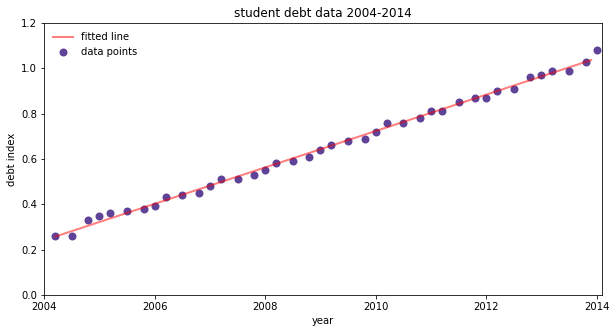

In [11]:
# create range of x values to plot regression line
x_fit = np.arange(min(x), max(x), .1)
y_fit = w[1]*x_fit + w[0]

# setup plot
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(frameon = 1)

# plot points and fitted line
fig_lin, =  ax.plot(x_fit, y_fit, color = [1, 0, 0], linewidth = 2, alpha = .5)
fig_pts = ax.scatter(x, y, color = plt_clrs[1], linewidth = 2, alpha = 1)

## set axis parameters
xtick_vals = list(np.arange(2004, 2015, 2))
xtick_labs = [str(i) for i in xtick_vals]

ax.set_xticks(xtick_vals), ax.set_xticklabels(xtick_labs)
ax.set_xlim([np.floor(min(x)), np.ceil(max(x)) + .1])
ax.set_ylim([np.floor(min(y)), np.round(max(y), 1) + .1])

# set labels
ax.set_xlabel('year')
ax.set_ylabel('debt index')
ax.set_title('student debt data 2004-2014')

# plot legend
ax.legend([fig_lin, fig_pts], ['fitted line', 'data points'], frameon = 0)

# set global plot parameters
plt.rcParams['font.size'] = '12'

plt.show()

**3.2** We now use the fitted line to predict student debt in 2050

In [12]:
pred_debt = w[1]*2050 + w[0]
print('predicted debt in 2050: ' + str(round(pred_debt, 2)))

predicted debt in 2050: 3.94


## **Exercise 4** *Linear regression with optimization* {-}

In the following exercises we implement linear regression using gradient descent to optimize the cost function.

*note: as noted in the question, it is possible to implement linear regression on this dataset exactly, using the same approach taken in **Ex 3**.*

We begin by importing the new dataset, which contains body mass (kg; *predictor*) and metabolic rate (KJ/day; *response*) values for a variety of animals. Max Kleiber, who collected the data in the early 1900s, noticed the following linear relationship between the natural log of these variables:

$$
w_0 + \log({x_p}) w_1 \simeq \log({y_p}) \space ,
$$

where $x_p$ and $y_p$ represent body mass and and metabolic rate, respectively, for observation (animal) $p$.

In [13]:
# read in data
datapath = '/Users/matthewbain/Documents/Math/courses/semester II/PHYS 3G03/3G0 assignments/HW 2/code/'
csvname = datapath + 'kleibers_law_data.csv'
data = np.asarray(pd.read_csv(csvname, header = None))

**4.1** In this exercise we define our model and cost function

We define the model according to the function above and the cost function based on the least squares sum.

In [14]:
### define model - takes model params in vector w, point x_p; returns y_p
# note that again, we pad with ones (add column of ones for intercept term)

# model = lambda x, w: np.exp(w[0] + np.log(x)*w[1])
model = lambda x, w: np.exp((np.log(x)).T * w)

In [15]:
### define least squares function
def least_squares( ):

    return 

In [16]:
model(5,5)

3124.999999999999

**4.2** We now minimize the cost function using gradient descent

In [17]:

### perform gradient descent to find minimum
# set params
g = least_squares
alpha = .01
max_its = 1000
w = np.array([1,2]) # from init pos in input space, locate optimal params of fit

# run gradient descent
weight_history, cost_history = gradient_descent(g, alpha, max_its, w)

TypeError: least_squares() takes 0 positional arguments but 1 was given

**4.3** Below we plot our results

In [ ]:
### plot cost function

### plot data and overlay fitted line

**4.4** We can now use our fitted model to predict how many calories an animal weighing 10 kg requires

*note: 1 calorie = 4.18 J*